<a href="https://colab.research.google.com/github/dekings44/students_companion_bot/blob/main/student_companion_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -U transformers --quiet
!pip install -U accelerate --quiet
!pip install -U bertviz --quiet
!pip install -U umap-learn --quiet
!pip install torch==2.1.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.6 MB/s eta 0:00:00


In [5]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


import torch
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
#from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Masters Project/dataset.csv')

In [7]:
data.head()

,Sentence,Type
0,"Ali, who was two at the time, loved the story ...",Auditory
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory
2,Believe me it's far more difficult to know wha...,Auditory
3,"The Surrealists loved bad movies, seeing them ...",Auditory
4,"He idolised prize-fighters, regarded racketeer...",Auditory


In [8]:
data['Type'].value_counts()

Visual         5827
Kinesthetic    4819
Auditory       4804
Name: Type, dtype: int64

In [9]:
num_rows, num_columns = data.shape
f'This dataset has {num_rows} rows and {num_columns} columns'

'This dataset has 15450 rows and 2 columns'

In [10]:
classes = data['Type'].unique()
classes

array(['Auditory', 'Visual', 'Kinesthetic'], dtype=object)

In [11]:
# # Shuffle the DataFrame
# data = data.sample(frac=1, random_state=42)

# # Print the shuffled DataFrame
# data.head()

In [12]:
# This Function is to clean the dataset and remove the noise
def cleanData(data):
  data = re.sub(r'@[A-Za-z0-9_]+', '', data) # this will remove the @ mentions
  data = re.sub(r'#', '', data) # this will remove the # symbols
  data = re.sub(r'https?:\/\/\s+', '', data) # This will remove the hyperlink
  data = re.sub(r'\n+', '', data) # This will removes all mention of \n
  data = re.sub(r'_', '', data) # This will remove _
  data = re.sub(r'[0-9]', '', data) # This will remove numbers
  return data

In [13]:
data['cleaned_conversation'] = data['Sentence'].apply(cleanData)

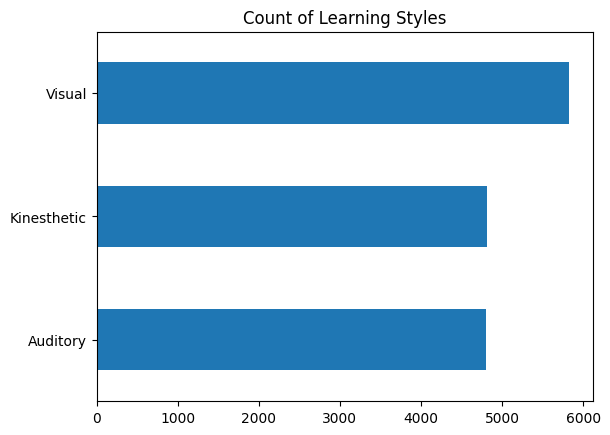

In [14]:
learning_styles = data['Type'].value_counts(ascending=True)
learning_styles.plot.barh()
plt.title('Count of Learning Styles')
plt.show()

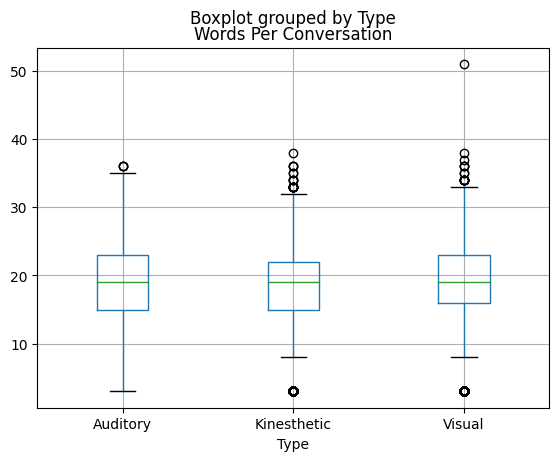

In [15]:
data['Words Per Conversation'] = data['cleaned_conversation'].str.split().apply(len)
data.boxplot("Words Per Conversation", by='Type')
plt.show()

In [16]:
# Assuming df is your DataFrame and 'Type' is the column with labels
labels = data['Type']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
numerical_labels = label_encoder.fit_transform(labels)

# Add the numerical labels to the DataFrame as a new column, let's call it 'Label'
data['Label'] = numerical_labels

In [17]:
classes = data['Label'].unique()
classes

array([0, 2, 1])

In [18]:
data.head()

,Sentence,Type,cleaned_conversation,Words Per Conversation,Label
0,"Ali, who was two at the time, loved the story ...",Auditory,"Ali, who was two at the time, loved the story ...",27,0
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory,"Look at my dad, spiffed up in jodhpurs, ready ...",16,0
2,Believe me it's far more difficult to know wha...,Auditory,Believe me it's far more difficult to know wha...,21,0
3,"The Surrealists loved bad movies, seeing them ...",Auditory,"The Surrealists loved bad movies, seeing them ...",16,0
4,"He idolised prize-fighters, regarded racketeer...",Auditory,"He idolised prize-fighters, regarded racketeer...",19,0


In [19]:
data.shape

(15450, 5)

In [20]:
sentences = data['cleaned_conversation'].tolist()
learn_style = data['Label'].tolist()

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

#tokenized_inputs_array =  np.array(tokenized_inputs) #tokenized_inputs.numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model1 = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
tokenized_inputs1 = tokenizer1(sentences, padding=True, truncation=True, return_tensors='pt')

#tokenized_inputs_array =  np.array(tokenized_inputs) #tokenized_inputs.numpy()

In [22]:
tokenized_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [23]:
tokenized_inputs['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [24]:
input_ids = tokenized_inputs['input_ids']
token_type_ids = tokenized_inputs['token_type_ids']
attention_mask = tokenized_inputs['attention_mask']

In [ ]:
input_ids1 = tokenized_inputs1['input_ids']
attention_mask1 = tokenized_inputs1['attention_mask']

In [25]:
# Splitting the dataset for BERT model
train_input_ids, test_input_ids, train_token_type_ids, test_token_type_ids, train_attention_mask, test_attention_mask, train_labels, test_labels = train_test_split(
    input_ids, token_type_ids, attention_mask, learn_style, test_size=0.2, random_state=42
)

train_input_ids, val_input_ids, train_token_type_ids, val_token_type_ids, train_attention_mask, val_attention_mask, train_labels, val_labels = train_test_split(
    train_input_ids, train_token_type_ids, train_attention_mask, train_labels, test_size=0.1, random_state=42
)

In [ ]:
Splitting the dattrain_input_ids1, test_input_ids1,  train_attention_mask1, test_attention_mask1, train_labels1, test_labels1 = train_test_split(
    input_ids1, attention_mask1, learn_style, test_size=0.2, random_state=42
)

train_input_ids1, val_input_ids1, train_attention_mask1, val_attention_mask1, train_labels1, val_labels1 = train_test_split(
    train_input_ids1, train_attention_mask1, train_labels1, test_size=0.1, random_state=42
)aset for DistilBERT model


In [26]:
#Convert into Pytorch BERT model
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_mask, torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(val_input_ids, val_attention_mask, torch.tensor(val_labels))
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_mask, torch.tensor(test_labels))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
Convert into Pytorch DistilBERT model
train_dataset1 = torch.utils.data.TensorDataset(train_input_ids1, train_attention_mask1, torch.tensor(train_labels))
val_dataset1 = torch.utils.data.TensorDataset(val_input_ids1, val_attention_mask1, torch.tensor(val_labels))
test_dataset1 = torch.utils.data.TensorDataset(test_input_ids1, test_attention_mask1, torch.tensor(test_labels))

train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=8, shuffle=True)
val_loader1 = torch.utils.data.DataLoader(val_dataset1, batch_size=8, shuffle=False)
test_loader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=8, shuffle=False)

In [ ]:
Train and validate DistilBERT on 10 Epochs
model1 = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
optimizer = AdamW(model1.parameters(), lr=2e-5)

for epoch in range(10):  # Adjust the number of epochs as needed
    model1.train()
    for batch in train_loader1:
        inputs, attention_mask, labels = batch
        outputs = model1(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    model1.eval()
    val_predictions = []
    for batch in val_loader1:
        inputs, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model1(inputs, attention_mask=attention_mask)
            logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).tolist()
        val_predictions.extend(predictions)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    print(f'Epoch {epoch + 1} - Validation Accuracy: {val_accuracy}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Validation Accuracy: 0.9538834951456311
Epoch 2 - Validation Accuracy: 0.9506472491909385
Epoch 3 - Validation Accuracy: 0.9457928802588996
Epoch 4 - Validation Accuracy: 0.9546925566343042
Epoch 5 - Validation Accuracy: 0.9538834951456311
Epoch 6 - Validation Accuracy: 0.9498381877022654
Epoch 7 - Validation Accuracy: 0.9530744336569579
Epoch 8 - Validation Accuracy: 0.9522653721682848
Epoch 9 - Validation Accuracy: 0.9490291262135923
Epoch 10 - Validation Accuracy: 0.9522653721682848


In [ ]:
model1.save_pretrained("/content/drive/MyDrive/Masters Project/")
model1.eval()
test_predictions = []
for batch in test_loader:
    inputs, attention_mask, labels = batch
    with torch.no_grad():
        outputs = model1(inputs, attention_mask=attention_mask)
        logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()
    test_predictions.extend(predictions)

test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.9540453074433657


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(5):  # Adjust the number of epochs as needed
    model.train()
    for batch in train_loader:
        inputs, attention_mask, labels = batch
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    model.eval()
    val_predictions = []
    for batch in val_loader:
        inputs, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).tolist()
        val_predictions.extend(predictions)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    print(f'Epoch {epoch + 1} - Validation Accuracy: {val_accuracy}')



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  Decoupled weight decay to apply.


Epoch 1 - Validation Accuracy: 0.9466019417475728
Epoch 2 - Validation Accuracy: 0.9457928802588996
Epoch 3 - Validation Accuracy: 0.9514563106796117
Epoch 4 - Validation Accuracy: 0.9563106796116505
Epoch 5 - Validation Accuracy: 0.9506472491909385


In [27]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(2):  # Adjust the number of epochs as needed
    model.train()
    for batch in train_loader:
        inputs, attention_mask, labels = batch
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    model.eval()
    val_predictions = []
    for batch in val_loader:
        inputs, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).tolist()
        val_predictions.extend(predictions)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    print(f'Epoch {epoch + 1} - Validation Accuracy: {val_accuracy}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  Decoupled weight decay to apply.


Epoch 1 - Validation Accuracy: 0.9530744336569579
Epoch 2 - Validation Accuracy: 0.959546925566343


In [28]:
model.save_pretrained("/content/drive/MyDrive/Masters Project/")
model.eval()
test_predictions = []
for batch in test_loader:
    inputs, attention_mask, labels = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=attention_mask)
        logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()
    test_predictions.extend(predictions)

test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')


Test Accuracy: 0.9527508090614887


In [36]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the trained model
model_path = "/content/drive/MyDrive/Masters Project/"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Input text to test
input_text = "audio is my thing, I like listening to music all the time"

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

# Ensure correct input formatting
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Feed the input to the model for prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Get the predicted label
predicted_label = torch.argmax(logits, dim=1).item()
print(f"Predicted Label Index: {predicted_label}")


Predicted Label Index: 0


In [3]:
!pip install torch torchvision torchaudio --quiet

In [2]:
!pip install gradio  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 9.6 MB

In [1]:
import gradio as gr
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [23]:
import os
# Load the trained model
model_path = "/content/drive/MyDrive/Masters Project/"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def predict_learning_style(text1, text2, text3, text4, text5):
    all_inputs = [text1, text2, text3, text4, text5]
    # Combine all input texts into a single string
    combined_text = '\n'.join(all_inputs)

    # Tokenize the combined text
    inputs = tokenizer(combined_text, return_tensors="pt")


    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Feed the input to the model for prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get the predicted label
    predicted_labels = torch.argmax(logits, dim=1).item()

    if predicted_labels == 0:
        learning_style = "You are an Auditory learner"
    elif predicted_labels == 1:
        learning_style = "You are a Kinesthetic learner"
    else:
        learning_style = "You are a Visual learner"

    return learning_style

# Interface setup using Gradio
text_input = gr.Textbox(label='Question 1: How do you find your way when you are in a journey?', lines=2)
text_input1 = gr.Textbox(label='Question 2: You have finished a competition/test, how would you like to receive your feedback?', lines=2)
text_input2 = gr.Textbox(label='Question 3: You would like to learn a new IT skill, what type of material would you like to use?', lines=2)
text_input3 = gr.Textbox(label='Question 4: You want to find out about a trip you are interested in, how would you go about it?', lines=2)
text_input4 = gr.Textbox(label='Question 5: When you learn from the internet, what type of material would you use?', lines=2)

output_text = gr.Label(label="Predicted Learning Style")

gr.Interface(
    fn=predict_learning_style,
    inputs=[text_input, text_input1, text_input2, text_input3, text_input4],
    outputs=output_text,
    title = 'Student Companion Bot',
    examples = [['Ask people around for help', 'I would prefer to be called', 'audibooks and podcast would help', 'I will call the trip company', 'I would like articles'],
                ['I would use the instruction at the bus stops', 'I would like the result sent via email', 'animated tutorial with clear infographics', 'I will check their website', 'infographics, article and images'],
                ['ask people who have expeirnce to guide me', 'any method will be fine', 'I will use material that guides me on getting hands-on', 'I can ask someone that has experience with that trip', 'practical based courses will do it for me']],
    description = "Hello 👋, I am an AI Bot trained to predict your learning style based on your response. Please flag 🚩 my prediction if you are not satisfied with it, I train on it to make more accurate prediction in my next version 😊",

    theme = 'HaleyCH/HaleyCH_Theme'


).launch(share=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e241f08c9a250ee0b4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
